# [0] 연구 목표 수립

- 유사 서비스
    - 구글 번역, 파파고, 카카오 번역
    - 언어 감지 파트 구현 (머신러닝), 기계 번역(딥러닝) 생략 혹은 API로 비슷하게 구현도 가능
    - **알파벳을** 사용하는 국가들의 알파벳 **사용 빈도**를 학습하여서말뭉치가 들어오면 어떤 국가인지 확률로 예측하여 제공(영어, 프랑스어, 타갈리아어, 인도네시아)
    - 분류문제 해결해보자

- 주장의 근거
    - 논문을 통해서 해결
    - 많은 데이터가 필요(기준)
    - 많은 데이터를 통해서 EDA로 해결

- 방법
    - 대륙별 4개국 (영어, 프랑스어, 타갈리아어, 인도네시아)에 동일한 내용을 담고 있는 텍스트 제공
        - 윈도우 설명서, ...
    
    - 피처
        - 전처리 방법
            - - 텍스트 -> a-z까지 추출(정규식) -> 빈도 계싼(a:150, b:400 ..)-> 피처 생성
            - 피처수 : 26
            - 데이터 : 국가수 * 국가별데이터수(동수)
    - 정답
        - 범주형, 국가코드 (en, fr, id, tl)
    - 최종피처
        - 데이터가 20개라면
        - 훈련데이터 볼륨
            - (20, 26 + 1)
            - 데이터가 적어서 신뢰성은 부족

- 알고리즘
    - 베이스라인으로 성능 무시하고 간단한 SVM으로 진행(설정)
- 최종 산출물
    - AWS 기반 + flask 서비스 + 모델 서빙
        - 나중에 확장 CI/CD 적용까지?
            - git Action or 젠킨스

# [1] 데이터 수집

- /content/drive/MyDrive/ASAC/Python 머신러닝/data/train

In [1]:
import glob
files =  glob.glob('/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/*')
files.sort()
files
# 한국어와 일본어는 분석 대상이 아니다 -> 미리 제외하자!

['/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/en-1.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/en-2.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/en-3.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/en-4.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/en-5.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/fr-10.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/fr-6.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/fr-7.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/fr-8.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/fr-9.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/id-11.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/id-12.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/id-13.txt',
 '/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/id-14.txt',
 '/content/driv

# [2] 데이터 준비

- (20,26+1)로 DF구성

## 정답 추출 모듈

In [2]:
# 샘플 점검 => 파일명에서 국가코드 추출
# 문자열로 처리
code = []

files[0].split('/')[-1].split('-')[0]

'en'

In [3]:
# 모듈 활용
import os

os.path.basename(files[0])[:2]

'en'

In [4]:
code = []
for i in range(20) :
    code.append(files[i].split('/')[-1].split('-')[0])

code

['en',
 'en',
 'en',
 'en',
 'en',
 'fr',
 'fr',
 'fr',
 'fr',
 'fr',
 'id',
 'id',
 'id',
 'id',
 'id',
 'tl',
 'tl',
 'tl',
 'tl',
 'tl']

In [5]:
def get_label(filename : str) -> str:
    return filename.split('/')[-1][:2]

get_label(files[0])

'en'

## 피처 생성
- 빈도 카운트 추출
- 말뭉치 -> a-z만 남김 -> 카운트 체크 -> 26(알파벳 문자개수)개의 맴버를 가진 리스트로 출력
- 최종 산출물 : 함수, 리턴값 리스트(26 len)

In [6]:
import re
from collections import Counter

# files[0] 파일에서 말뭉치 추출
# I/O에서는 통산 with문 사용
with open (files[0]) as f:
    # 대문자 => 소문자 바로 처리
    text = f.read().lower()
    # 샘플링
    # print(text[:100])
    # a-z만 남김 (a-z)빼고 제거 -> sub -> 정규식
    p = re.compile('[^a-z]*')
    text = p.sub('', text)
    # 알파벳 문자별 카운트 구현 => 파이썬
    # 결과 [10, 4, 2, 2, 4, 2 ... , 100) 이런 형식으로 나온다
    # 해석 a가 10회 b가 4회 , ... z가 100회 등장했다
    counts = [0]*26
    # 아스키 코드 특징을 활용하여 변환 및 알파벳별 count
    STD_A_ASCII = ord('a') # ord() : ASCII로 변환해주는 함수
    for ch in text:
        # 만약 a가 나왔다 -> counts[0] += 1
        # 만약 b가 나왔다 -> counts[1] += 1
        # 만약 z가 나왔다 -> counts[25] += 1
        counts[ord(ch) - STD_A_ASCII] += 1
    print(counts)

[349, 59, 210, 212, 484, 72, 88, 201, 340, 8, 25, 247, 121, 356, 412, 76, 0, 357, 282, 370, 119, 45, 65, 3, 92, 2]


In [7]:
with open (files[0]) as f:
    text = f.read().lower()
    p = re.compile('[^a-z]*')
    text = p.sub('', text)
    counts = [0]*26
    STD_A_ASCII = ord('a')
    for ch in text:
        counts[ord(ch) - STD_A_ASCII] += 1
    # 제일 작은 값 0, 제일 큰 값 484 -> 값의 편차가 크다 => 값의 간격을 좁히자
    # 피처 스케일링 -> 간격 0 ~ 1 사이로 변환
    # 개별 빈도 / 전체빈도 => 언어별 문자의 비중 (영향력) => 총합은 1.0
    # 전체빈도
    total_count = sum(counts)
    # 데이터 => 개별빈도/전체빈도 => 0~1 사이로 변환 => 피처스케일링 or 정규화
    # 학습 정확도를 높이기 위한 수단으로 진행
    count_norms = []
    for count in counts :
        count_norms.append(count / total_count)
    # counts_norms = lost(map(lambda x:x/total_count, counts))

In [8]:
len(files)

20

In [9]:
# 최종 산출물 => 함수

'''
    함수명 : encode_freqs_data
    인자 : dir = 'train'
    출력 :
    {
        'freqs':[
            [...],
            [...],

        ],
        'labels':[
            'en', 'fr'
        ]
    }
'''
import glob
files =  glob.glob('/content/drive/MyDrive/ASAC/Python 머신러닝/data/train/*')
files.sort()
files

code = []
for i in range(20) :
    code.append(files[i].split('/')[-1].split('-')[0])

code

def get_label(filename : str) -> str:
    return filename.split('/')[-1][:2]

get_label(files[0])
def encode_freqs_data(dir) :
    files =  glob.glob('/content/drive/MyDrive/ASAC/Python 머신러닝/data/'+ dir +'/*')
    files.sort()
    len_files = len(files)
    freqs = []
    labels = []
    for i in range(len_files):
        labels.append(files[i].split('/')[-1].split('-')[0])
        with open (files[i]) as f:
            text = f.read().lower()
            p = re.compile('[^a-z]*')
            text = p.sub('', text)
            counts = [0]*26
            STD_A_ASCII = ord('a')
            for ch in text:
                counts[ord(ch) - STD_A_ASCII] += 1
            total_count = sum(counts)
            count_norms = []
            for count in counts :
                count_norms.append(count / total_count)
            freqs.append(count_norms)

    return {'freqs' : freqs, 'labels' : labels}

encode_freqs_data('train')

{'freqs': [[0.07595212187159957,
   0.012840043525571273,
   0.04570184983677911,
   0.04613710554951034,
   0.10533188248095757,
   0.015669205658324265,
   0.019151251360174103,
   0.043743199129488576,
   0.07399347116430903,
   0.0017410228509249185,
   0.00544069640914037,
   0.05375408052230685,
   0.026332970620239392,
   0.07747551686615888,
   0.08966267682263329,
   0.016539717083786723,
   0.0,
   0.07769314472252448,
   0.061371055495103376,
   0.08052230685527748,
   0.02589771490750816,
   0.009793253536452665,
   0.014145810663764961,
   0.0006528835690968443,
   0.02002176278563656,
   0.0004352557127312296],
  [0.08417789436031954,
   0.019911768212710148,
   0.030404196971503518,
   0.038869679265529984,
   0.13699773458924527,
   0.017407893167998092,
   0.031238821986407535,
   0.02742339334684631,
   0.07535471563133421,
   0.0026231071896983425,
   0.009777035888875641,
   0.042327411470132345,
   0.024204125432216526,
   0.05353523309884345,
   0.0687969476570883

In [10]:
train_raw_data = encode_freqs_data('train')
test_raw_data = encode_freqs_data('test')

In [11]:
# 3단계, 데이터 준비에 최종 결과물 덤프 => json 혹은 다른 형식(바이너리)
import json

with open('freqs_labels.json', 'w') as f:
    json.dump([train_raw_data, test_raw_data], f)

# [3] 데이터 분석 - EDA(간단)
- 알파벳 단어의 빈도가 언어를 구분하는지 시각적 분석 진행

## [3-1] 데이터 로드

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [13]:
with open('freqs_labels.json') as f:
    data = json.load(f)

train_data, test_data = data

In [14]:
# df_freqs 생성 (20, 26)
from string import ascii_lowercase
df_train = pd.DataFrame(train_data['freqs'], columns = list(ascii_lowercase))
df_train.shape

(20, 26)

In [15]:
# 정답 데이터 추가, 칼럼명(레이블명) => label = (20, 26+1)
df_train['label'] = train_data['labels']

In [16]:
df_train.head()

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,label
0,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,...,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
1,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,...,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en
2,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,...,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553,en
3,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,...,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697,en
4,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,...,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,en


## [3-2] EDA

In [17]:
# df_train 데이터 사용
# x축 a ~ z, y축 빈도(평균), 바차트, 언어별 1개씩 차트가 나옴
# 언어별 => 범주형 => 4개만 존재 => 피벗의 타겟이 된다

# 인덱스에 범주형 => 데이터가 모두 평균으로 계산되어서 배치
# (4,26)
df_train_pv = df_train.pivot_table(index = df_train.label)
df_train_pv

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
label,,,,,,,,,,,,,,,,,,,,,
en,0.075558,0.018601,0.036565,0.039376,0.124937,0.016977,0.023900,0.042127,0.074847,0.002329,...,0.001592,0.070693,0.070782,0.085701,0.026975,0.011627,0.016694,0.002466,0.016232,0.000788
fr,0.076183,0.013140,0.036707,0.049217,0.150272,0.012729,0.013278,0.014709,0.077658,0.003138,...,0.005976,0.077309,0.074177,0.067647,0.049076,0.013363,0.001796,0.004234,0.004813,0.000915
id,0.160047,0.026276,0.008391,0.038213,0.085395,0.008259,0.044496,0.017399,0.095626,0.006473,...,0.000036,0.056469,0.061414,0.049494,0.044268,0.003768,0.004730,0.000725,0.012463,0.000807
tl,0.210537,0.021824,0.010842,0.019756,0.041240,0.003260,0.075524,0.014543,0.078540,0.001603,...,0.000680,0.030609,0.054899,0.051996,0.030127,0.002815,0.009956,0.000430,0.025048,0.001396


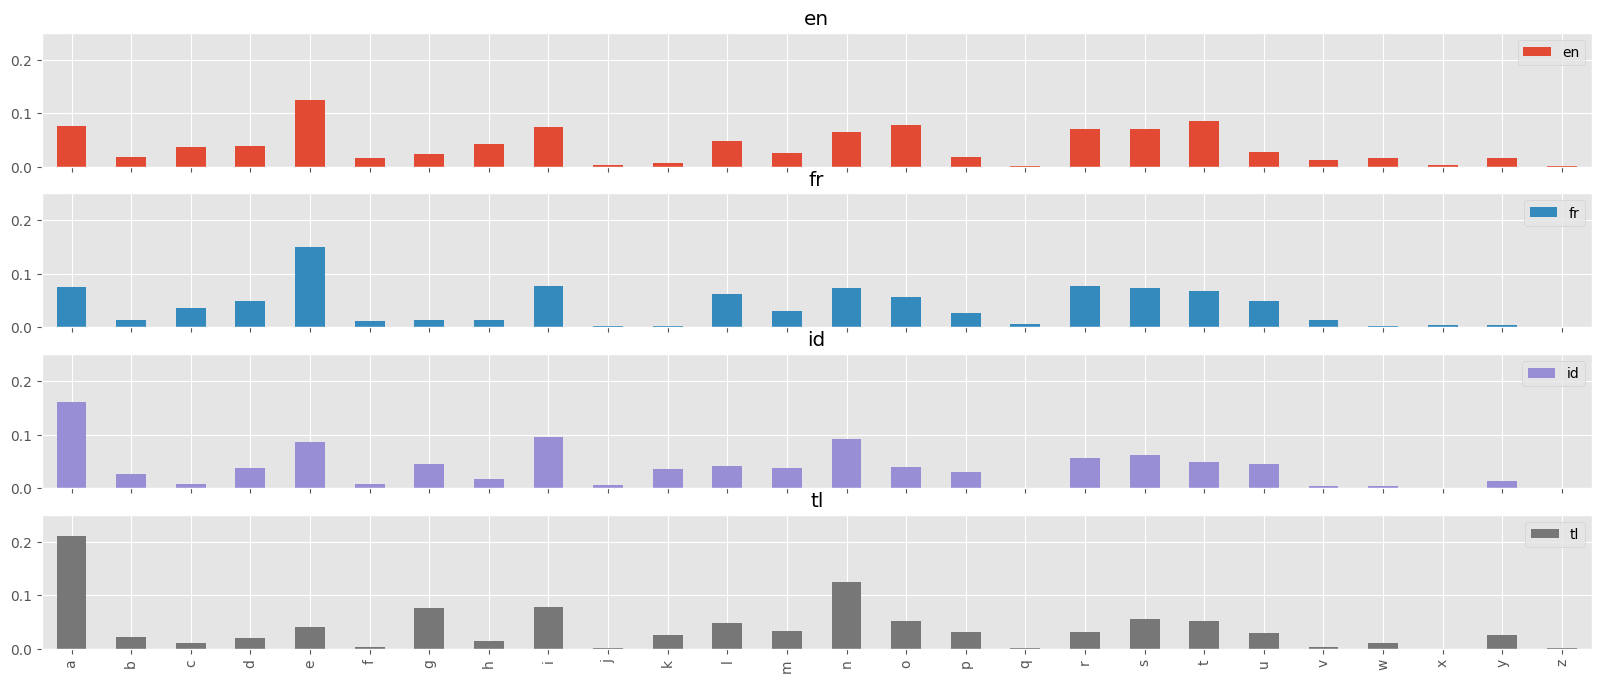

In [18]:
# df_train 데이터 사용
# x축 a ~ z, y축 빈도(평균), 바차트, 언어별 1개씩 차트가 나옴
# 언어별 => 범주형 => 4개만 존재 => 피벗의 타겟이 된다
plt.style.use('ggplot')

df_train_pv.T.plot(kind = 'bar', subplots = True, figsize = (20,8), ylim = (0, 0.25))

plt.show()

<Axes: >

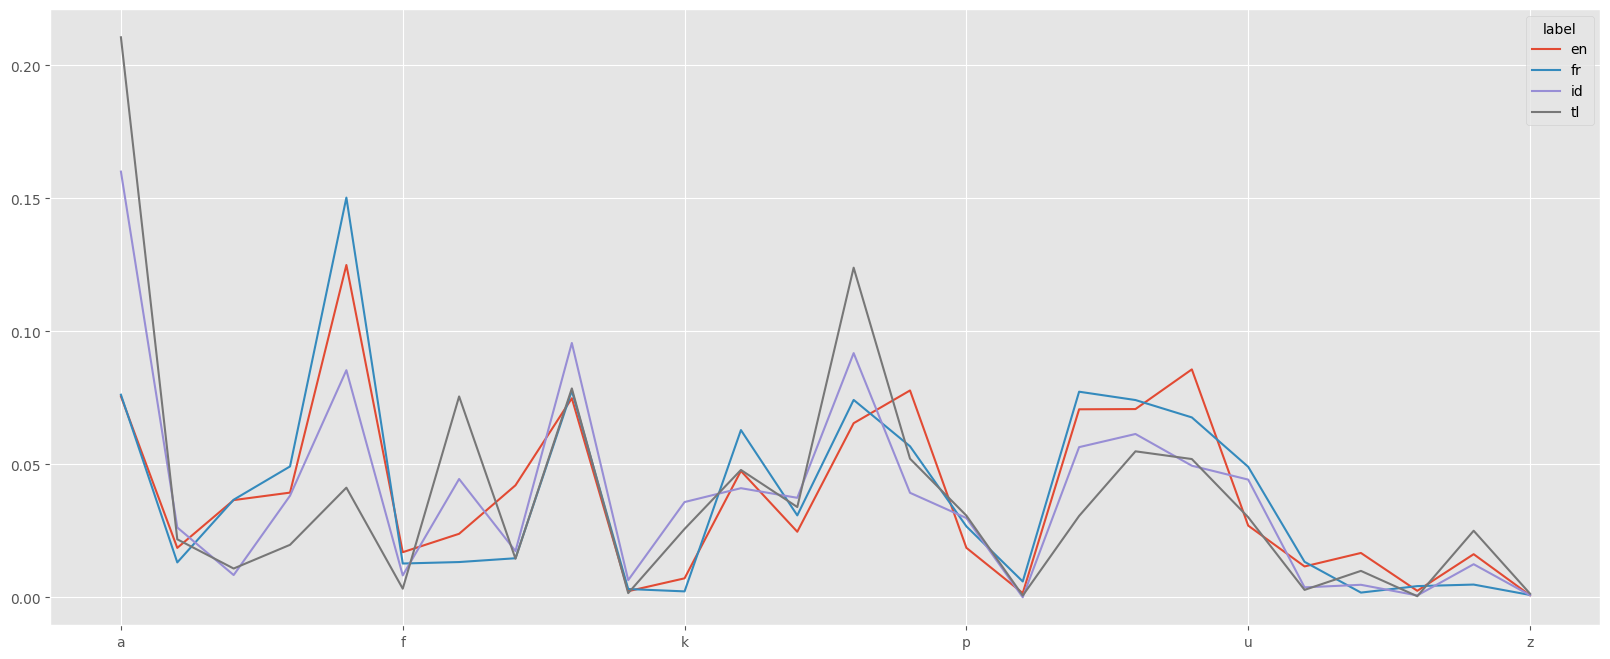

In [19]:
# x축 a-z, y축 평균빈도, 차트 1개, 범례(국가코드)는 4개
df_train_pv.T.plot( kind='line', figsize=(20, 8) )
# 빈도의 추세는 유사하게 보인다
# 디테일한 빈도값의 차이는 확실하게 존재한다
# 이 부분(빈도차이)을 머신러닝에 학습시키면 좋은 결과가 예상 -> 예측확률이 높을 것으로 예상

In [20]:
df_train.label.unique(), df_train_pv.index

(array(['en', 'fr', 'id', 'tl'], dtype=object),
 Index(['en', 'fr', 'id', 'tl'], dtype='object', name='label'))

a


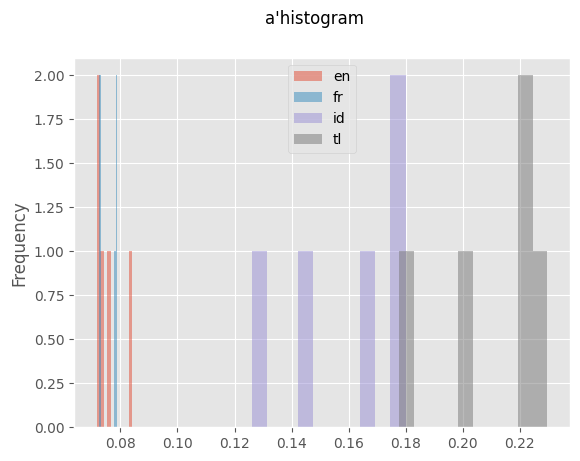

In [21]:
# 알파벳별로 히스토그램을 사용하여 언어별 빈도 점유를 살펴본다
# 겹치는 구간과 동떨어진 구간이 보일것이다 => 이 차이를 학습한다
# a-z 반복, 단 a 처리후 break
for ch in ascii_lowercase:
    print(ch)
    # 국가별 a 데이터만 추출 => 총 4회 수행
    for na in df_train.label.unique():
        # 국가별 a 데이터만 df_train에서 추출 => (5,)
        tmp = df_train[df_train.label == na][ch]
        #print( na, tmp.shape )
        # 히스토그램, 국가별 데이터를 반투명하게 플로팅
        tmp.plot(kind = 'hist', alpha = 0.5, label = na)
    break

plt.legend()
plt.suptitle(f'{ch}\'histogram')
plt.show()

# en, fr과 id, tl은 a의 분포도 만으로도 상호 구분이 된다. (단, 다른 문자 확인 필요)
# 단, en과 fr은 많이 겹치므로 다음 문자들의 빈도도 확인하여 구분하기 위한 각각의 가중치값이 필요하다!
# id, tl은 각각 고유영역이 있고 일부분만 겹친다
# a-z까지 각각 EDA 필요

# [4] 모델 구축 (머신러닝 혹은 딥러닝)

- 대표 라이브라리
    - scikit-learn : https://scikit-learn.org/stable/index.html
- 서비스가 적용될 클라우드(인프라)/서비스가 운영되는 환경의 버전과 맞춰야 한다
- 최종 산출물
    - 모델 덤프 파일 제공
        - 덤프용 라이브러리
            - joblib, 피클
        - 사용법 함수로 제공

### [4-1] 사용 패키지 버전 조정/체크

In [22]:
# 환경에 맞춰서 실행
#!pip install scikit-learn == 1.0.2

In [23]:
import sklearn

sklearn.__version__

'1.2.2'

### [4-2] 피처엔지니어링 (생략)

- 훈련용, 테스트용 데이터 준비
    - 황금비율 : 775:25 통상적으로 그렇다
    - 50:25:25 = 훈련 : 검증 : 테스트

In [24]:
# 2차원 구조의 알파벳 빈도를 가진 리스트
X = train_data['freqs']
# 1차원 구조의 정답을 가진 리스트
y = train_data['labels']

In [25]:
len(X), len(y), len(X[0])

(20, 20, 26)

### [4-3] 베이스라인 구축

#### [4-3-1] 알고리즘 선택

- 선택
    - 경험적, 이론적 선택
    - 캐글 등 대회에서 좋은 성능을 내는 모델
    - 알고리즘 선택시트
    <img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F5jrjo%2Fbtqy1hHyoLW%2FNkJczWLx5spl1KK7Bi5QV0%2Fimg.png'>
    - 베이스라인 구축을 통해서 기본 모델(성능에 관계없이) 선택
        - 로지스틱 회귀
        - svm

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

#### [4-3-2] 학습
- sklearn => fit() 함수로 통일
- 커스텀 구성하여 학습(흔하지 않다)
- 기법
    - K폴드 교차 검증 기법 학습
    - 층화 K폴드 교차 검증 기법 학습
        - 레이블 불균형할 때

- 방식 => MLOps
    - 오프라인 학습
        - 훈련 따로, 시스템 반영 따로
        - 실시간 반영 X
        - 모델 서빙시 시스템 셧다운 진행 (점검)

    - 온라인 학습
        - 시스템 유지, 업데이트된 모델이 실시간 자동 반영
        - 리스크 존재

In [27]:
# 학습
clf.fit(X, y)

RandomForestClassifier()

#### [4-3-3] 예측

- 학습에 사용되지 않은, 한번도 접하지 않은 데이터
    - 테스트 데이터 일반적으로 활용

In [28]:
X_ = test_data['freqs']
# 리스트 구조라서 간단하게 확안
len(X_), len(X_[0])

(8, 26)

In [30]:
# 예측 -> 테스트 데이터는 훈련데이터와 동일한 shape 구조 (피처수 동일)
pred_y = clf.predict(X_)
# 예측의 값은 => 'en', ...
pred_y

array(['en', 'en', 'fr', 'fr', 'id', 'id', 'tl', 'tl'], dtype='<U2')

#### [4-3-4] 성능평가

- 분류
    - 혼동행렬을 이용하여
        - 정확도, 정밀도, 재현율, f1-score
        - auc, roc
        
- 회귀
    - 손실값 (실제값, 예측값 사이 차이값)
    - mse, rmse, ...
    - 통상적으로 값이 낮을수록 좋다

In [33]:
from sklearn import metrics

metrics.accuracy_score(test_data['labels'], pred_y)

# 정확도 1.0 => 과적합 => 데이터가 적었기 때문

1.0

In [34]:
# 평가도구 -> 정확도, 정밀도, 재현율, f1-score 동시에 확인
print(metrics.classification_report(test_data['labels'], pred_y))

              precision    recall  f1-score   support

          en       1.00      1.00      1.00         2
          fr       1.00      1.00      1.00         2
          id       1.00      1.00      1.00         2
          tl       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



### [4-3] 최적화 (최적화 알고리즘 + 최적 하이퍼파라미터 시뮬레이션)

#### [4-3-1] 전통적인 기법
- 하이퍼파라미터 튜닝
- 교차 검증, 랜덤서치...
- 파이프라인 구축
- 베이지안 최적화

#### [4-3-2] 자동화
- 파이캐럿
- AutoML

####[4-3-3] 모델 덤프


In [35]:
import joblib

joblib.__version__

'1.3.2'

In [36]:
# 모델 덤프
joblib.dump(clf, '/content/drive/MyDrive/ASAC/Python 머신러닝/data/lang_predict.ml')


['/content/drive/MyDrive/ASAC/Python 머신러닝/data/lang_predict.ml']

In [37]:
# 정답 덤프
target = {
    'en' : '영어'
    ,'fr' : '프랑스어'
    ,'id' : '인도네시아어'
    ,'gl' : '타갈리아어'
}

joblib.dump(target, '/content/drive/MyDrive/ASAC/Python 머신러닝/data/lang_predict.lb' )

['/content/drive/MyDrive/ASAC/Python 머신러닝/data/lang_predict.lb']

#### 모델 설명법

- 파라미터
    - 말뭉치 -> a-z만 남기고 제거 -> 카운트 -> 정규화 -> [[비중, 비중, ...]] 모델에 입력한다
    - xx.py 형태로 제공

# [5] 시스템 구축 (모델 서빙 및 AWS 서비스 구축) => MLOps

- flask 사용 - 로컬 PC
    - git 연동 (생략)
    - ci/cd => devops 절차
    - 가상환경 구축
        - 파이썬 기반 구성
            - $python -m venv <가상환경이름>
                - 가상환경 생성
                    - $python -m venv <가상환경이름>
                    - $python -m venv svr
                - 현재 위치 이동
                    - $cd web_svr/Scripts
                - 목록 확인
                    - $ls
                - 화면 클리어
                    - $clear
            - 가상환경 활성화 하기
                - 윈도우
                    - activate
                - 맥

        - 아나콘다(미니콘다)

- aws ec2 or cloud9
